In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib
from matplotlib import image

from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import h5py as h5py
import pickle
import os, cv2
from PIL import Image
import math



%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load Data

In [2]:
# img_urls = np.loadtxt('faces.csv', dtype=np.str)

In [3]:
def load_images_from_urls(urls):
    for i in range(len(urls)):
        try:
            urllib.request.urlretrieve(urls[i], 'images/img' + str(i) +'.png' )
        except:
            continue

# Try Basic-Yolo-Keras implementation

In [4]:
PATH_CFG = "tiny-yolo-voc-darknet/tiny-yolo-voc.cfg"
PATH_WEIGHTS_DARKNET = "tiny-yolo-voc-darknet/tiny-yolo-voc.weights"
anchors = np.fromfile('tiny-yolo-voc-keras/tiny-yolo_anchors.txt', sep=', ')
IMAGE_W = 416
CHANNELS = 3
LABELS = 20
GRID = 13
CELL_WIDTH = IMAGE_W / GRID
BOX = LABELS+5
ANCHORS = int(len(anchors) / 2)
# Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
#  Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
#  Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
#  Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
#  Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
#  Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
#  Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
#  Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
#  Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
#  Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 256)
#  Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 13, 13, 512)
#  Load  |  Yep!  | maxp 2x2p0_1                     | (?, 13, 13, 512)
#  Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 13, 13, 1024)
#  Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 13, 13, 1024)
#  Load  |  Yep!  | conv 1x1p0_1    linear           | (?, 13, 13, 125)

In [5]:
x_input = Input((IMAGE_W, IMAGE_W, CHANNELS))

#1
x = Conv2D(kernel_size=(3,3), filters=16, strides=(1,1), padding='SAME', name='conv2d_1', use_bias=False)(x_input)
x = BatchNormalization(name='batch_normalization_1')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2,2))(x)

#2
x = Conv2D(kernel_size=(3,3), filters=32, strides=(1,1), padding='SAME', name='conv2d_2', use_bias=False)(x)
x = BatchNormalization(name='batch_normalization_2')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2,2))(x)

#3
x = Conv2D(kernel_size=(3,3), filters=64, strides=(1,1), padding='SAME', name='conv2d_3', use_bias=False)(x)
x = BatchNormalization(name='batch_normalization_3')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2,2))(x)

#4
x = Conv2D(kernel_size=(3,3), filters=128, strides=(1,1), padding='SAME', name='conv2d_4', use_bias=False)(x)
x = BatchNormalization(name='batch_normalization_4')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2,2))(x)

#5
x = Conv2D(kernel_size=(3,3), filters=256, strides=(1,1), padding='SAME', name='conv2d_5', use_bias=False)(x)
x = BatchNormalization(name='batch_normalization_5')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2,2))(x)

#6
x = Conv2D(kernel_size=(3,3), filters=512, strides=(1,1), padding='SAME', name='conv2d_6', use_bias=False)(x)
x = BatchNormalization(name='batch_normalization_6')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2,2), strides=(1,1), padding='SAME')(x)

#7
x = Conv2D(kernel_size=(3,3), filters=1024, strides=(1,1), padding='SAME', name='conv2d_7', use_bias=False)(x)
x = BatchNormalization(name='batch_normalization_7')(x)
x = LeakyReLU()(x)

#8
x = Conv2D(kernel_size=(3,3), filters=1024, strides=(1,1), padding='SAME', name='conv2d_8', use_bias=False)(x)
x = BatchNormalization(name='batch_normalization_8')(x)
x = LeakyReLU()(x)

x = Conv2D(kernel_size=(1,1), filters=125, strides=(1,1), padding='SAME', name='conv2d_9')(x)

model = Model(inputs=x_input, outputs=x)

In [6]:
model.load_weights('tiny-yolo-voc-keras/tiny-yolo-voc.h5')

In [7]:
image = plt.imread('street.jpg')
resized = cv2.resize(image, (IMAGE_W, IMAGE_W))
image_data = np.expand_dims(resized, axis=0)
image_data = image_data
model.predict(image_data)

array([[[[-9.32819366e+01,  1.73876480e+02, -4.42053223e+02, ...,
           1.85315466e+03, -2.27983761e+01,  1.11552332e+03],
         [-1.13066238e+02,  1.48657455e+01, -9.20101440e+02, ...,
           2.84849902e+03,  6.92343811e+02,  2.24860864e+03],
         [ 3.03096039e+02,  4.47278595e+02, -1.29788501e+03, ...,
           2.40257690e+03,  1.14031995e+03,  2.69218091e+03],
         ...,
         [-1.78642853e+02,  4.32805359e+02, -5.14701965e+02, ...,
           1.04188550e+03,  1.18671265e+03,  2.21693433e+03],
         [ 1.77022171e+02,  9.46437317e+02, -5.29688965e+02, ...,
           1.16546497e+03,  4.96951996e+02,  1.95342200e+03],
         [ 4.63095978e+02,  6.81086060e+02, -4.83205566e+02, ...,
           8.65824524e+02, -3.41580844e+00,  1.13167603e+03]],

        [[-1.74720856e+02,  2.07038376e+02, -6.57596375e+02, ...,
           2.33626465e+03,  2.01556747e+02,  8.08713135e+02],
         [ 7.44041138e+01,  3.70872711e+02, -1.14944543e+03, ...,
           3.71480859e

In [8]:
class Box:
    def __init__(self):
        c,x,y,w,h = [float() for i in range(5)]

In [9]:
def box_intersection(a, b):
    w = overlap(a.x, a.w, b.x, b.w);
    h = overlap(a.y, a.h, b.y, b.h);
    if w < 0 or h < 0: return 0;
    area = w * h;
    return area;

def box_union(a, b):
    i = box_intersection(a, b);
    u = a.w * a.h + b.w * b.h - i;
    return u;

def box_iou(a, b):
    return box_intersection(a, b) / box_union(a, b);

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [24]:
def parse_netout(netout):
    boxes_confidences = np.array([netout[:,:,i*BOX + 5] for i in range(ANCHORS)])
    boxes = np.array([netout[:,:,(i*BOX) : (i*BOX + 4)] for i in range(ANCHORS)])
    boxes_class_probs = np.array([netout[:,:,(i*BOX + 5) : (i*BOX + BOX)] for i in range(ANCHORS)])    
    boxes_confs_flat = np.reshape(boxes_confidences,
                                  (boxes_confidences.shape[0],
                                   -1))
    boxes_confs_flat = np.expand_dims(boxes_confs_flat, axis=-1)
    boxes_class_probs_flat = np.reshape(boxes_class_probs,
                                  (boxes_class_probs.shape[0],
                                   -1,
                                   boxes_class_probs.shape[3]))
    boxes_scores_flat = np.array([boxes_confs_flat[i] * boxes_class_probs_flat[i] for i in range(ANCHORS)])
    boxes_scores = np.reshape(boxes_scores_flat, (boxes_class_probs.shape[0],
                                                 boxes_class_probs.shape[1],
                                                 boxes_class_probs.shape[2],
                                                 boxes_class_probs.shape[3]))
    
    boxes_classes = np.argmax(boxes_scores, axis=-1)
    boxes_scores = np.take(boxes_scores, boxes_classes)
    
    W, H, _ = netout.shape
    
    for row in range(W):
        for col in range(H):
            for b in range(ANCHORS):
                boxes[b, row, col, 0] = (sigmoid(boxes[b, row, col, 0]) + col) / W
                boxes[b, row, col, 1] = (sigmoid(boxes[b, row, col, 1]) + row) / H
                boxes[b, row, col, 2] = anchors[b*2] * np.exp(boxes[b, row, col, 2]) / W
                boxes[b, row, col, 3] = anchors[b*2 + 1] * np.exp(boxes[b, row, col, 3]) / H
                if boxes[b, row, col, 2] == float('inf'):
                    boxes[b, row, col, 2] = 90000
                if boxes[b, row, col, 3] == float('inf'):
                    boxes[b, row, col, 3] = 90000 
    
    adjusted_boxes = np.reshape(boxes, (-1, boxes.shape[-1]))
    
    adjusted_boxes[:,0] = adjusted_boxes[:,0] - adjusted_boxes[:,2] / 2
    adjusted_boxes[:,1] = adjusted_boxes[:,1] - adjusted_boxes[:,3] / 2
    adjusted_boxes[:,2] = adjusted_boxes[:,0] + adjusted_boxes[:,2]
    adjusted_boxes[:,3] = adjusted_boxes[:,1] + adjusted_boxes[:,3]
    
    return boxes_classes, boxes_scores, adjusted_boxes

In [12]:
test_netout = np.random.rand(13,13,425)
boxes_classes, boxes_scores, boxes = parse_netout(test_netout)
print("boxes_classes: ", boxes_classes.shape)
print("boxes_scores: ", boxes_scores.shape)
print("boxes: ", boxes.shape)

boxes_classes:  (5, 13, 13)
boxes_scores:  (5, 13, 13)
boxes:  (845, 4)


In [96]:
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    return boxes[0:100]
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [97]:
test_netout = np.random.rand(13,13,425)
boxes_classes, boxes_scores, boxes = parse_netout(test_netout)
print("not suppressed: ", boxes.shape)
suppressed = non_max_suppression_fast(boxes, 0.5)
print("suppressed: ", suppressed.shape)

not suppressed:  (845, 4)
suppressed:  (100, 4)


In [98]:
def netout_to_boxes(netout, anchors):
    _,_,boxes = parse_netout(netout)
    return non_max_suppression_fast(boxes, 0.9)

In [99]:
def frame_func(image):
    resized = cv2.resize(image, (IMAGE_W, IMAGE_W)) / 255.
    batch = np.expand_dims(resized, axis=0)
    out = model.predict(batch)[0]
    boxes = netout_to_boxes(out, anchors)
    return draw_box(boxes,image)

In [100]:
def draw_box(boxes,im):
    w, h, _ = im.shape
    imgcv = im
    for i in range(boxes.shape[0]):
        
        x1 = boxes[i,0] * w
        y1 = boxes[i,1] * h
        x2 = boxes[i,2] * w
        y2 = boxes[i,3] * h
        
        x1 = x1 if x1 > 0 else 1
        y1 = y1 if y1 > 0 else 1
        x2 = x2 if x2 > 0 else 1
        y2 = y2 if y2 > 0 else 1
        
        x1 = int(x1) if x1 < imgcv.shape[0] else imgcv.shape[0] - 1
        y1 = int(y1) if y1 < imgcv.shape[1] else imgcv.shape[1] - 1
        x2 = int(x2) if x2 < imgcv.shape[0] else imgcv.shape[0] - 1
        y2 = int(y2) if y2 < imgcv.shape[1] else imgcv.shape[1] - 1
        
        
#         print("after")
#         print("x1: ", x1)
#         print("y1: ", y1)
#         print("x2: ", x2)
#         print("y2: ", y2)
        
        cv2.rectangle(imgcv, (x1, y1), (x2, y2), (255,65,86), 3)

    return imgcv

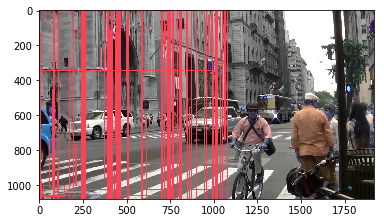

In [101]:
image = cv2.imread('street.jpg')
plt.imshow(frame_func(image))

In [95]:
from darkflow.net.build import TFNet
import cv2

options = {"model": PATH_CFG, "load": PATH_WEIGHTS_DARKNET, "threshold": 0.1}

tfnet = TFNet(options)

imgcv = cv2.imread("street.jpg")
result = tfnet.return_predict(imgcv)
print(result)

/Users/UnicornKing/Projects/ML/Face_Detection/darkflow/dark/darknet.py:54: UserWarning: ./cfg/tiny-yolo-voc.cfg not found, use tiny-yolo-voc-darknet/tiny-yolo-voc.cfg instead
  cfg_path, FLAGS.model))


Parsing tiny-yolo-voc-darknet/tiny-yolo-voc.cfg
Loading tiny-yolo-voc-darknet/tiny-yolo-voc.weights ...
Successfully identified 63471556 bytes
Finished in 0.24513888359069824s
Model has a VOC model name, loading VOC labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 

In [43]:
def frame_func_darkflow(image):
    out = tfnet.return_predict(image)
    boxes = netout_to_boxes(out, anchors)
    return draw_box(boxes,image)

In [56]:
def draw_boxes_darkflow(image, boxes):
    imgcv = image
    for i in range(len(boxes)):
        x1 = boxes[i]["topleft"]["x"]
        y1 = boxes[i]["topleft"]["y"]
        x2 = boxes[i]["bottomright"]["x"]
        y2 = boxes[i]["bottomright"]["y"]
        cv2.rectangle(imgcv, (x1, y1), (x2, y2), (255,76,25), 3)

    return imgcv

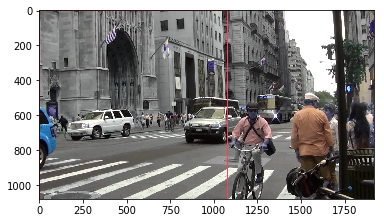

In [88]:
image = cv2.imread('street.jpg')
plt.imshow(frame_func_darkflow(image))

In [23]:
plt.imshow(draw_boxes_darkflow(image, result))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
1.14597686e-01